# LING 2010 Statistics for Linguistics Research Final Project <a name="TOP"></a>
Anthony Verardi | 4.22.2020 | a.verardi@pitt.edu | [GitHub](https://github.com/AnthonyVerardi)

This Notebook was prepared as a "final paper" for **LING 2010: Statistics for Research in Linguistics** with [Dr. Melinda Fricke](http://www.pitt.edu/~mdf46/Home.html) at the University of Pittsburgh during the Spring 2020 semester.

All of the data presented in this Notebook comes from a personally modified version of the [Arabic Learner Corpus](https://arabiclearnercorpus.com) (ALC), which is freely available for download, modification, and redistribution under a [Creative Commons Attribution-NonCommercial 4.0 International (CC BY-NC 4.0) license](https://creativecommons.org/licenses/by-nc/4.0/).

**Table of Contents**
1. [Data Synopsis](#DS)
1. [Hypothesis](#HYP)
    1. [Chi-Squared Predictions](#CH2P)
    1. [Mixed-Effects Linear Regression Predictions](#MERP)
1. [Test 1: Chi-Squared Test](#CH2)
    1. [Meeting Assumptions](#MA1)
    1. [Code Walkthrough](#CW1)
    1. [Visualizations](#VIS1)
    1. [Interpretation](#INT1)
1. [Test 2: Linear Mixed-Effects Regression](#MER)
    1. [Meeting Assumptions](#MA2)
    1. [Code Walkthrough](#CW2)
    1. [Visualizations](#VIS2)
    1. [Interpretation](#INT2)
1. [Works Referenced](#WR)

## 1. Data Synopsis <a name="DS"></a>

The data from the ALC were collected in Saudi Arabia in 2012 and 2013, featuring both written and spoken responses to one of two prompt genres: 
* a **narrative** detailing their favorite vacation ever taken
* a **discussion** of their academic plan of study

All 942 participants were learners of Modern Standard Arabic (MSA), although nearly half of all responses collected come from L1 Arabic speakers of a local dialect (790 out of 1,585 total responses). The other half of the participants come from a variety of language and geopolitical backgrounds. The full dataset includes the raw text in Arabic of each participant's response.

The modified dataset that I'm using for this analysis only contains a portion of the metadata columns that the original had to offer and does not include the full text responses (exporting from Python to a .csv proved problematic for preserving Arabic-language texts). In detail, the 16 columns used are:

* 'Participant': a unique participant identifier starting with S and followed by 3 digits; truncated from the original system
* 'TestNumber': the number of the test represented by the specific observation of data from a given participant. TestNumber of 2 indicates that this is the participant's *second test recorded,* for example. Ranges from 1-5.
* 'L1': the first language of the participant
* 'L1family': the broader language family to which the participant's L1 belongs
* 'NumLangs': the number of languages known by the participant, ranging from 1-10
* 'Nationality': the nationality of the participant, 67 nationalities represented
* 'Age': the age of the participant, ranges from 16-42
* 'Gender': the gender of the participant, here only given as "Female" or "Male"
* 'YearsStudy': how many years the participant has studied MSA, ranges from 0-19
* 'GenLvl': whether the participant is pre or post-university in their studies
* 'LvlStdy': whether the participant is in a BA program, MA program, diploma course, language school, or secondary school
* 'Genre': the genre of the text as mentioned above, either narrative or discussion
* 'Mode': whether the text was recorded as writing or speech
* 'TextLen': the length of the text in words (*not* morphological units)
* 'TitleLen': the length of the text's title in words (*not* morphological units)
* 'TTR': the type/token ratio found in the text, i.e. the ratio of unique word **types** to total number of word **tokens**

In [1]:
# Loading in necessary packages for this paper

library(car)
library(ggplot2)
library(lme4)
library(reshape)
library(vcd)

Warning message:
"package 'car' was built under R version 3.6.2"Loading required package: carData
Warning message:
"package 'ggplot2' was built under R version 3.6.2"Warning message:
"package 'lme4' was built under R version 3.6.3"Loading required package: Matrix
Registered S3 methods overwritten by 'lme4':
  method                          from
  cooks.distance.influence.merMod car 
  influence.merMod                car 
  dfbeta.influence.merMod         car 
  dfbetas.influence.merMod        car 
Warning message:
"package 'reshape' was built under R version 3.6.3"
Attaching package: 'reshape'

The following object is masked from 'package:Matrix':

    expand

Warning message:
"package 'vcd' was built under R version 3.6.3"Loading required package: grid


In [2]:
# Reading in a .csv file that contains all of the relevant corpus data we'll be using from the ALC
# and saving the full table as an object in R
read.csv("ArabicLearnerCorpus.csv") -> ALC

In [3]:
# Examining the first six rows to make sure the import went smoothly, and to show how the data is formatted
head(ALC)

Participant,TestNumber,L1,L1family,NumLangs,Nationality,Age,Gender,YearsStudy,GenLvl,LvlStdy,Genre,Mode,TextLen,TitleLen,TTR
S001,1,Moore,NigerCongo,4,Burkina Faso,20,Male,14,Pre-university,Diploma course,Narrative,Written,169,6,0.7988166
S001,2,Moore,NigerCongo,4,Burkina Faso,20,Male,14,Pre-university,Diploma course,Discussion,Written,161,9,0.8447205
S002,1,Russian,Slavic,5,Russian,25,Male,5,Pre-university,Diploma course,Narrative,Written,317,3,0.6372240
S002,2,Russian,Slavic,5,Russian,25,Male,5,Pre-university,Diploma course,Discussion,Written,173,3,0.7572254
S003,1,Tatar,Turkic,4,Russian,24,Male,6,Pre-university,Diploma course,Narrative,Written,133,3,0.7669173
S003,2,Tatar,Turkic,4,Russian,24,Male,6,Pre-university,Diploma course,Discussion,Written,70,3,0.7285714


The following cell is intended to verify that our data has been loaded properly:

In [4]:
# First prints out the dimensions of our dataset (rows x columns), then the column names
dim(ALC)
names(ALC)

[1] 1585   16

[1] "Participant" "TestNumber"  "L1"          "L1family"    "NumLangs"   
 [6] "Nationality" "Age"         "Gender"      "YearsStudy"  "GenLvl"     
[11] "LvlStdy"     "Genre"       "Mode"        "TextLen"     "TitleLen"   
[16] "TTR"

Additionally, for the current project, it will be necessary to add another column that has either "short", "medium", or "long" as a categorical label based on the response's length. The gradations of this new category were based on the observed *median* of the "TextLen" column (149), since outliers are very likely pulling the mean up to 185 in this dataset.  "Short" responses have 150 words or fewer, "medium" responses are between 151-300 words, and "long" responses have 301 or more words.

In [5]:
ALC$TextLen -> ALC$LenCats # Duplicating the text lengths into a new column ("length as categories")
factor(ALC$LenCats, levels = c("short", "med", "long")) -> ALC$LenCats # Creating level names for "short", "medium", and "long" text categories

In [6]:
ALC[ALC$TextLen <= 150, ]$LenCats <- "short"
ALC[ALC$TextLen >= 151 & ALC$TextLen <= 300, ]$LenCats <- "med"
ALC[ALC$TextLen >= 301, ]$LenCats <- "long"

In [7]:
# Should now show us the new column
head(ALC)

Participant,TestNumber,L1,L1family,NumLangs,Nationality,Age,Gender,YearsStudy,GenLvl,LvlStdy,Genre,Mode,TextLen,TitleLen,TTR,LenCats
S001,1,Moore,NigerCongo,4,Burkina Faso,20,Male,14,Pre-university,Diploma course,Narrative,Written,169,6,0.7988166,med
S001,2,Moore,NigerCongo,4,Burkina Faso,20,Male,14,Pre-university,Diploma course,Discussion,Written,161,9,0.8447205,med
S002,1,Russian,Slavic,5,Russian,25,Male,5,Pre-university,Diploma course,Narrative,Written,317,3,0.6372240,long
S002,2,Russian,Slavic,5,Russian,25,Male,5,Pre-university,Diploma course,Discussion,Written,173,3,0.7572254,med
S003,1,Tatar,Turkic,4,Russian,24,Male,6,Pre-university,Diploma course,Narrative,Written,133,3,0.7669173,short
S003,2,Tatar,Turkic,4,Russian,24,Male,6,Pre-university,Diploma course,Discussion,Written,70,3,0.7285714,short


Lastly, before we start our analysis, let's check our text length data for outliers and remove them, since they could have some serious effects on our results.

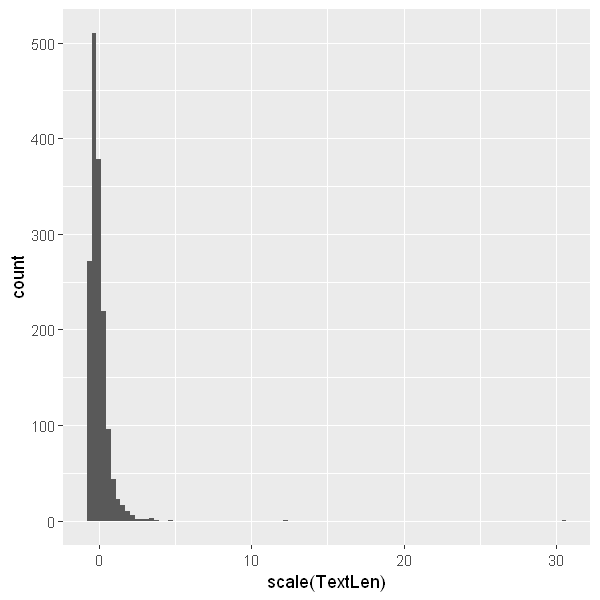

In [8]:
# Visualizing scaled text length as standard deviations as a histogram
options(repr.plot.width=5, repr.plot.height=5) # Resizing plot

ggplot(ALC,aes(scale(TextLen))) + geom_histogram(bins=100)

In [9]:
# Removing outliers farther than 3 standard deviations from the mean and printing the new dimensions
ALC[abs(scale(ALC$TextLen))<= 3,] -> ALCNO
dim(ALCNO)

[1] 1576   17

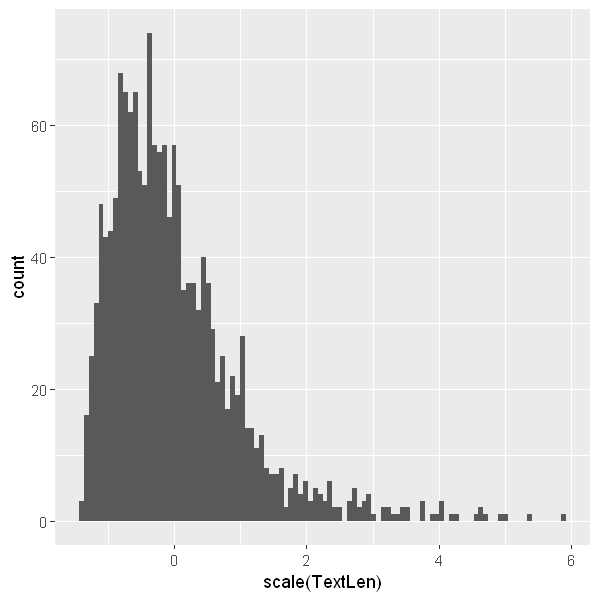

In [10]:
# Visualizing the reduced data set with outliers removed
options(repr.plot.width=5, repr.plot.height=5) # Resizing plot

ggplot(ALCNO,aes(scale(TextLen))) + geom_histogram(bins=100)

This is better. It's still very much right-skewed, but it's usable for our purposes. All data are accounted for at 1,576 observations of data (post-outlier removal), 17 columns of information. Here are some quick stats for each column:

In [11]:
summary(ALCNO)

  Participant     TestNumber          L1              L1family  
 S016   :   5   Min.   :1.000   Arabic :785   Arabic      :785  
 S505   :   5   1st Qu.:1.000   Chinese: 76   NigerCongo  :176  
 S005   :   4   Median :1.000   Urdu   : 64   Austronesian:127  
 S007   :   4   Mean   :1.448   Malay  : 46   IndoIran    :126  
 S009   :   4   3rd Qu.:2.000   French : 44   SinoTib     : 76  
 S014   :   4   Max.   :5.000   Fulani : 36   Italic      : 48  
 (Other):1550                   (Other):525   (Other)     :238  
    NumLangs        Nationality       Age          Gender       YearsStudy    
 Min.   : 1.000   Saudi   :717   Min.   :16.0   Female: 443   Min.   : 0.000  
 1st Qu.: 1.000   Chinese : 74   1st Qu.:17.0   Male  :1133   1st Qu.: 0.000  
 Median : 2.000   Filipino: 74   Median :21.0                 Median : 0.000  
 Mean   : 2.342   Guinean : 48   Mean   :20.7                 Mean   : 2.402  
 3rd Qu.: 3.000   Indian  : 42   3rd Qu.:23.0                 3rd Qu.: 3.000  
 Max. 

[Back to top](#TOP)

## 2. Hypothesis <a name="HYP"></a>

The current work aims to explore one research question, namely: does **genre of response prompt** (narrative or discussion) have a statistically significant effect on **text length** in this dataset? Intuitively, one might expect that participants would produce lenghtier responses when asked about their favorite vacation as opposed to their plans of study, which they might not have as much to say about. Conversely, it may also be that "plan of study"-discussion responses will be longer because the act of talking about oneself in the active, present tense is generally thought of in language pedagogy as a "lower-proficiency" task (ex. ACTFL, CEFR guidelines) compared to past-tense narration. In either case, it stands to reason that the genre of task used to collect a response may have an effect on its length.

The first way that I'll try to explore this question is by using a **Chi-Squared test,** and the second one is by using a **Mixed-Effects Linear Regression model.** The Chi-Squared test will rely on text length data that have been collapsed into "short", "medium", and "long" categorical groups, while the Mixed-Effects model will use the raw text length.

### 2A. Chi-Squared Predictions <a name="CH2P"></a>

For the Chi-Squared test, I predict that the genre of the response will have a statistically significant effect on the length of the response, and that on average, we will see larger counts of longer texts than predicted for texts in the "narrative" genre category and shorter texts patterning with the "discussion" category. A Chi-Squared test is appropriate here since we're dealing with two types of categorical variable (Genre: "narrative" vs. "discussion" and length: "short", "medium", "long") that have count data in each cell, and it is unclear as to whether the levels of genre are independent from the levels of length. In summation, I predict that the proportion of responses observed will vary from the estimated levels by genre, that the variables of "genre" and "length" are associated with one another, and that narrative genre responses imply longer response texts.

### 2B. Mixed-Effects Linear Regression Predictions <a name="MERP"></a>

For the Mixed-Effects Linear Regression model, I predict the same as I did for the Chi-Squared test: that the genre of the response will have a statistically significant effect on the length of the response, and that on average, we will see larger counts of longer texts than predicted for texts in the "narrative" genre category and shorter texts patterning with the "discussion" category. However, I will additionally include level of study ("LvlStdy") as a fixed effect as well, assuming that this may also affect text length (assuming that the higher a person's degree progress/level of education and hence their familiarity with the target language, the longer their response will likely be). Mixed-Effects modeling makes sense here because it will allow me to use the raw counts from my data instead of the categorical groups of "short", "medium", and "long" that were created for the Chi-Squared test; further, a Mixed-Effects model makes sense given that each row in the table represents one "trial" by a given participant, not some type of average across all trials or participants. This will remove a source of bias on my part in choosing what qualifies as a "short/medium/long" response. For this test, I will use "Genre" and "LvlStudy" as fixed effects (since there are discrete possible levels for both) and introduce a random effect of "Participant" into the model to account for individual variation.

[Back to top](#TOP)

## 3. Chi-Squared Test <a name="CH2"></a>
### 3A. Meeting Assumptions <a name="MA1"></a>
As Levshina points out, there are only two assumptions that must be met in order to perform a Chi-Squared test:

1. The sample is *randomly selected from the population of interest* and *the observations are independent.* 
2. Every observation can be classiied into exactly one category according to the criterion represented by each variable (Conover 1999: 204–205).

The second assumption provides no issue; each category is sufficiently different such that no response could go in either category. But the first assumption does actually pose a challenge: since our samples can be grouped by participant (some participants performed more than one test), we will have to account for that. I will do so by utilizing a subset of the corpus that only includes each participant's first test as a way of controlling for this.

~After subsetting the data, another issue becomes apparent: one of the cells (Discussion:long) only has two observations recorded, which is below the 5-observation threshold for using a Chi-Squared test. Instead, I'll use a **Fisher's Exact Test**, although to save time on editing this notebook, I will continue to refer to this section as Chi-Squared.~

After taking a moment to actually run both tests, it seems that using Chi-Squared as the actual test her may be a valid move. Unlike in Levshina's example on p.  213, running the Chi-Squared test on the subsetted data did not provide me with a warning message that the approximation may be incorrect. [This piece](https://towardsdatascience.com/fishers-exact-test-in-r-independence-test-for-a-small-sample-56965db48e87) also seems to indicate that the expected count cannot be lower than 5, but the observed counts may be.

### 3B. Code Walkthrough <a name="CW1"></a>

In [12]:
# Creating a subset of the ALC dataset where only the first trial from each participant is used
subset(ALCNO, TestNumber == 1) -> ALC.chi
dim(ALC.chi)

[1] 937  17

In [13]:
# Saving a table of genres and length categories as a variable for ease of use 
table(ALC.chi$Genre, ALC.chi$LenCats) -> chi
chi

            
             short med long
  Discussion    27  32    2
  Narrative    363 385  128

In [14]:
# Creating a table of *expected* values based on our data
chisq.test(chi)$expected

,short,med,long
Discussion,25.38954,27.14728,8.46318
Narrative,364.61046,389.85272,121.53682


In [15]:
# Taking that same expected values table and turning them into proportions
prop.table(chisq.test(chi)$expected)

,short,med,long
Discussion,0.02709663,0.02897255,0.00903221
Narrative,0.38912536,0.41606480,0.12970845


In [16]:
# Changing the "wide" table from above into a "long" one that ggplot will prefer
melt(chi) -> chi.df
chi.df

Var.1,Var.2,value
Discussion,short,27
Narrative,short,363
Discussion,med,32
Narrative,med,385
Discussion,long,2
Narrative,long,128


In [17]:
# Renaming columns to reflect their content more accurately
colnames(chi.df) <- c("Genre", "Length", "Frequency")
chi.df

Genre,Length,Frequency
Discussion,short,27
Narrative,short,363
Discussion,med,32
Narrative,med,385
Discussion,long,2
Narrative,long,128


In [18]:
# Changing raw values from the table into proportional values 
prop.table(chi,2)

            
                  short        med       long
  Discussion 0.06923077 0.07673861 0.01538462
  Narrative  0.93076923 0.92326139 0.98461538

In [19]:
# Running the actual Chi-Squared test; interpretation of results will follow in next subsection
chisq.test(chi)


	Pearson's Chi-squared test

data:  chi
X-squared = 6.3166, df = 2, p-value = 0.0425


In [20]:
# Checking which (if any) residuals are having a statistically significant effect;
# values above |1.96| typically considered significant

chisq.test(chi)$stdres

            
                  short        med       long
  Discussion  0.4326295  1.2930284 -2.4758837
  Narrative  -0.4326295 -1.2930284  2.4758837

### 3C. Visualizations <a name="VIS1"></a>
Here, we'll visualize a few different parts of our data for the Chi-Squared test. Let's start by making a dodged bar graph that shows the distribution of long, medium, and short responses colored by prompt genre (narrative or discussion). 

Saving 6.67 x 6.67 in image


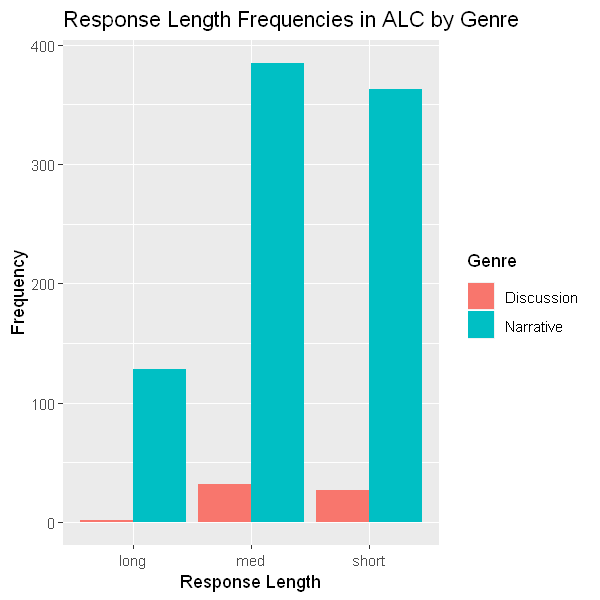

In [21]:
# Using the Chi-Squared dataframe from before to plot the observed frequencies
ggplot(chi.df, aes(Length, Frequency, fill=Genre))+ geom_bar(stat = "identity", position="dodge") +
xlab("Response Length") +
ggtitle("Response Length Frequencies in ALC by Genre")

# Saving the plot we just created in our current working directory as a 6.6x6.6 .png file
ggsave("chiCategories.png")

The "narrative" category has significantly more observations in general than the narrative category, but this should not be an issue for a Chi-Squared test, since it operates on proportionality and does not necessitate an even distribution of data. Unsurprisingly, the "long" responses are also smaller in count than either the "medium" or "short" categories, which are relatively even with each other. Now let's visualize the actual results of the Chi-Squared test itself:

png 
  2

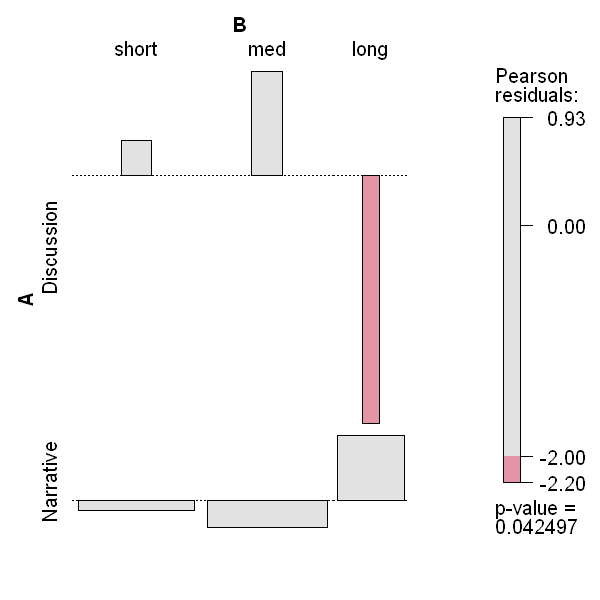

In [22]:
# Creating an association matrix
options(repr.plot.width=5, repr.plot.height=5) # Resizing plot

assoc(chi, shade=T)

# Saving it as a .png in our working directory
png("chiAssoc.png")
assoc(chi, shade=T)
dev.off()

Based on this visualization, we may conclude that the "long" category is the only one for which there is a statistically significant effect to examine, and it does not appear to be a very strong one at that; more discussion to follow.

### 3D. Interpretation <a name="INT1"></a>
From comparing the output of the observed distribution of our categorical text length data against the expected values, we can see that there is some fluctuation between the two, but it seems to be relatively minor except for in the discussion:long cell (~9 expected, 2 observed). The actual Chi-Squared statistic is 6.3166, which does not seem to be "large" enough to safely conclude that there are large differences between actual and expected counts beyond what chance might give us. With a *p*-value of only .0425, a weakly significant relationship does exist, but I do not think I would risk my reputation on these results when making a claim. If standardized Pearson residual values above |1.96| are typically considered "significant" here and the "discussion:long" residual is only -2.476, and the overall *p*-value is .0425, it doesn't seem that genre is having a very strong or reliable effect at all, and this is the categorical relationship that seems to be contributing the most to our overall results.

In summary: the variables "Genre" and "Text Length" are **not** independent, although the relationship between them is of weak significance (p <= .05) and the effect of genre on length seems most apparent and most impactful in the interaction between "discussion" prompts and "long" response lengths; discussion prompts do seem to weakly disfavor longer essays. All of the counts for discussion are actually lower than their expected values, but only "long" seems statistically significant; in other words, the initial hypothesis that narrative genre types would favor longer essays is cautiously correct at best (the evidence suggests that more testing may be necessary, and that other factors besides genre may be playing a role here) and may not hold up well under a different test (which may be (dis)proven in the next section by using a Mixed-Effects model).

[Back to top](#TOP)

## 4. Mixed-Effects Linear Regression <a name="MER"></a>
### 4A. Meeting Assumptions <a name="MA2"></a>
Since linear regression includes a number of assumptions that must be met, I'll be briefly detailing each of them here in a bullet point and then showing any necessary proofs below.

1. Observations are independent
    * Observations may be grouped by participant, but this has been accounted for as a random effect
1. Response variable is interval-or ratio-scaled
    * Yes, the response variable (TextLen) is ratio scaled; a response length of 0 is still meaningful as a non-reponse
1. Relationship between variables is (roughly) linear
    * Difficult to tell from the box plots alone since we're not working with categories that increase or decrease; both level of study and genre are discrete and can't really support "linear" modeling in the usual sense on their own
1. Homoscedasticity of variance
    * The variance seems heteroscedastic based on the linear model alone without random effects or interaction terms. See below 
    * Seems like the model has trouble with the higher end (right-side) of the fitted values
1. Explanatory variables are not strongly correlated
    * This at least should be fine; there is nothing intuitive to suggest that someone's level of academic study should impact which genre they are given for an experiment 
1. Residuals are not autocorrelated
    * Likely not, since this is not time series data; no observation should have an impact on another one
1. Residuals are normally distributed, with a mean of 0
    * Not true, and log transforming the entire model doesn't seem to help very much (the other tail dips); then again, closer on the whole

Still, all things being said and done, I do not think I would be the first person to violate these assumptions and still go ahead with their analysis, and I certainly will not be the last. We have discussed numerous times in class that researchers routinely use Mixed-Effects models for their robustness and seeming robustness in the face of violated assumptions. For the sake of learning, I plan to continue on with trying to fit a Mixed-Effects model to these data.

In [23]:
# Assuumption 3: Relationship between variables is roughly linear

# Creating a normal linear model to test if variance for genre and level of study is roughly linear
lm(TextLen ~ Genre + LvlStdy, data = ALCNO) -> lm

# Log-transforming the text length and fitting another linear model; this is more for Assumption 7
lm(log(TextLen) ~ Genre + LvlStdy, data = ALCNO) -> lmLOG

png 
  2

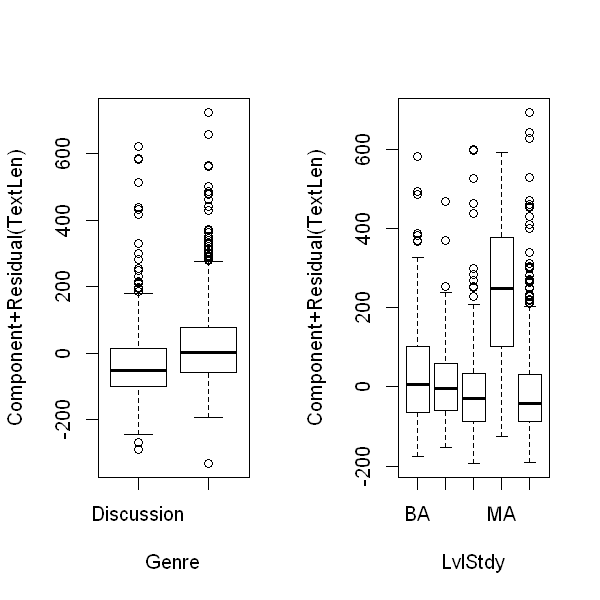

In [24]:
# Plotting component residuals for both genre and level of study 
par(mfrow=c(1,2))
crPlot(lm, var = "Genre")
crPlot(lm, var = "LvlStdy")
par(mfrow=c(1,1))

# Saving the above output as a .png
png("ALCLMResiduals.png")
par(mfrow=c(1,2))
crPlot(lm, var = "Genre")
crPlot(lm, var = "LvlStdy")
par(mfrow=c(1,1))
dev.off()

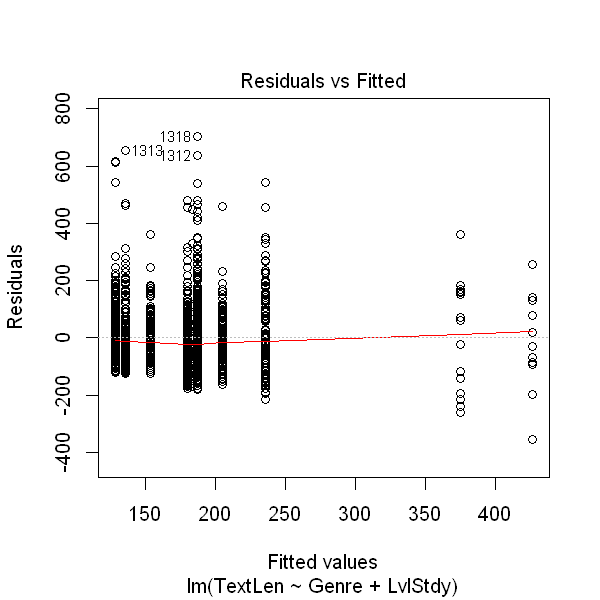

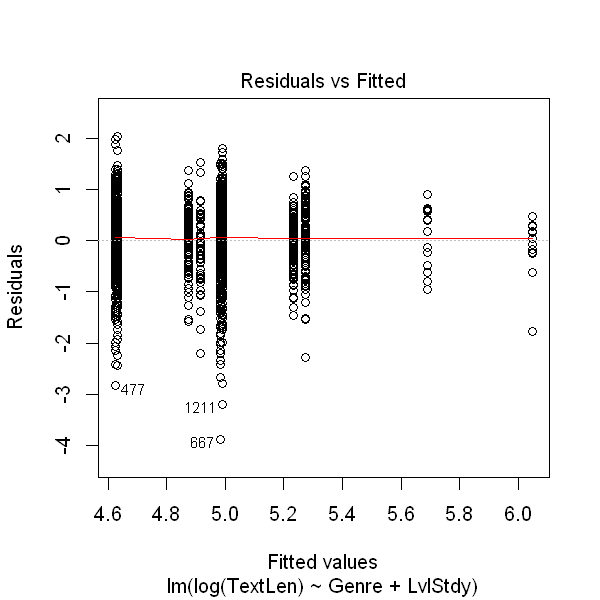

In [25]:
# Assumption 4: Homoscedasticity of Variance

# Plotting residuals vs. fitted for both linear models
options(repr.plot.width=5, repr.plot.height=5) # Resizing plot
plot(lm, which=1)
plot(lmLOG,which=1)

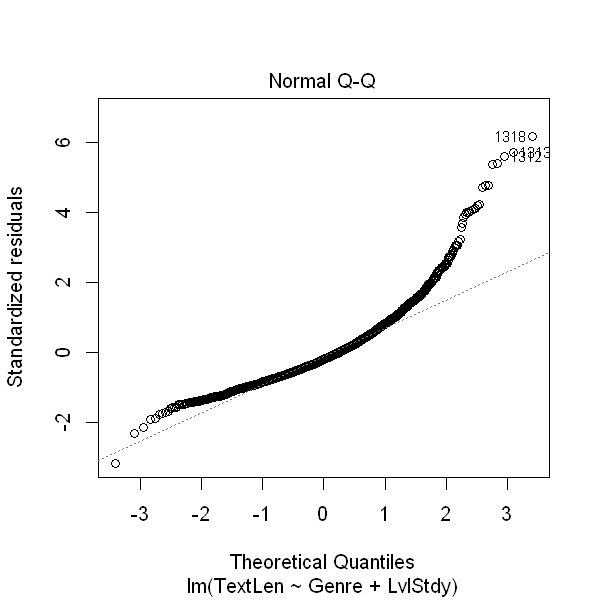

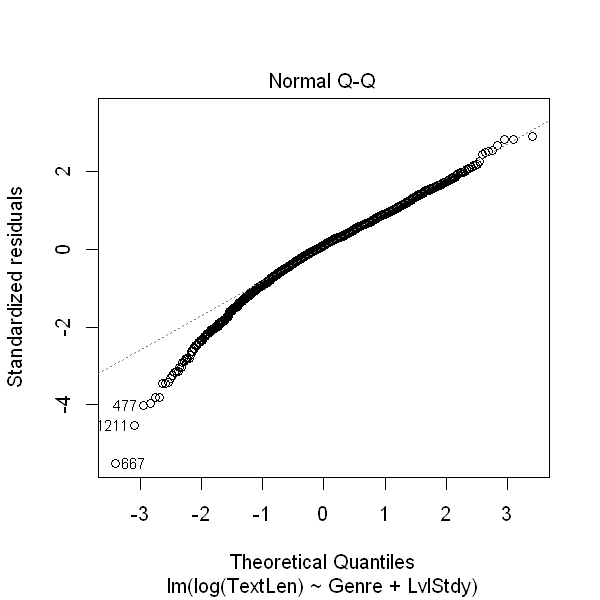

In [26]:
# Assumption 7: Residuals are normally distributed, with a mean of 0

# Again plotting both linear models
options(repr.plot.width=5, repr.plot.height=5) # Resizing plot


plot(lm, which=2)
plot(lmLOG, which=2)

### 4B. Code Walkthrough <a name="CW2"></a>

In [27]:
# Predict the text length by only estimating the overall intercept, plus a set of randomly varying intercepts
# that can vary by participant; set REML to "False" to allow for comparison of different models
lmer(TextLen ~ 1 + (1|Participant), data = ALCNO, REML = F) -> regr0

# Adding in fixed predictor "Genre"
lmer(TextLen ~ Genre + (1|Participant), data = ALCNO, REML = F) -> regr1

# Adding in fixed predictor "LvlStudy"
lmer(TextLen ~ Genre + LvlStdy + (1|Participant), data = ALCNO, REML = F) -> regr2

# Adding in an interaction effect for "genre" and "level of study"
lmer(TextLen ~ Genre * LvlStdy + (1|Participant), data = ALCNO, REML = F) -> regr3

In [28]:
anova(regr0, regr1, regr2, regr3)

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
regr0,3,19442.57,19458.65,-9718.283,19436.57,NA,NA,NA
regr1,4,19277.04,19298.50,-9634.522,19269.04,167.52043,1,2.574848e-38
regr2,8,19185.73,19228.63,-9584.864,19169.73,99.31637,4,1.375227e-20
regr3,12,19139.70,19204.05,-9557.848,19115.70,54.03248,4,5.180908e-11


Log likelihood increases with each nesting of the models, indicating that the likelihood that our predictors hold explanatory power is increasing.

In [29]:
summary(regr3)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: TextLen ~ Genre * LvlStdy + (1 | Participant)
   Data: ALCNO

     AIC      BIC   logLik deviance df.resid 
 19139.7  19204.0  -9557.8  19115.7     1564 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.5241 -0.4499 -0.0880  0.3239  6.1419 

Random effects:
 Groups      Name        Variance Std.Dev.
 Participant (Intercept) 6804     82.48   
 Residual                5735     75.73   
Number of obs: 1576, groups:  Participant, 941

Fixed effects:
                                       Estimate Std. Error t value
(Intercept)                             135.406     14.554   9.304
GenreNarrative                          113.944     14.134   8.062
LvlStdyDiploma course                    19.021     18.045   1.054
LvlStdyLanguage course                    7.071     16.218   0.436
LvlStdyMA                               246.960     32.963   7.492
LvlStdySecondary school                 -19.413     15.992  -1.214

### 4C. Visualizations <a name="VIS2"></a>

There's not as much to visualize here in terms of the actual model as there was above with the Chi-Squared test, but I still wanted to visualize text length as a function of genre for this section, with level of study being used to break them out further.

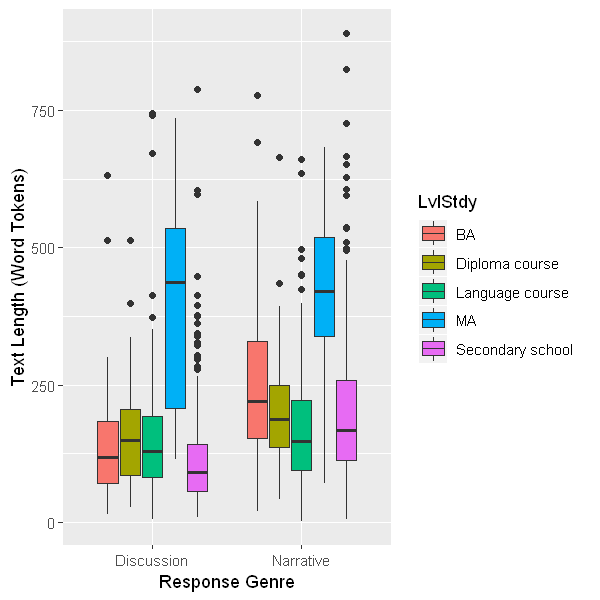

In [30]:
# Plotting text length as a function of genre, colored by level of study

ggplot(ALCNO, aes(Genre, TextLen, fill=LvlStdy)) +
geom_boxplot() +
xlab("Response Genre")+
ylab("Text Length (Word Tokens)")

It does look like genre has some role to play for participants in BA programs and Secondary school; in general, we see the same pattern of longer responses on average for narrative data that the Chi-Squared test only hinted at. The distribution for MA-level participants is intriguing in its wide variance for the discussion genre; people at the graduate education level may be better-equipped and more willing to talk about their studies, perhaps. I would love to visualize this model by participants, but since there are 900+ people represented here, it didn't seem like a great idea.

### 4D. Interpretation <a name="INT2"></a>

Aside from dubious validity on the grounds of violated assumptions, this went well! Every step of adding a new parameter or modifying an existing one resulted in an increase of log likelihood, meaning that each predictor seems to be giving us some additional explanatory power when building our model. However, the scaled residuals of the final model (regr3) are skewed, ranging from -3.52 to 6.14, with a median of -0.0880. In the grand scheme of things, this actually doesn’t seem terrible; although the far ends are skewed, the median is still fairly close to 0. Returning to my hypothesis, it does seem that genre is more clearly having an effect once the full dataset can be utilized and random effects can be considered by the algorithm.

Regarding the fixed effects selected for our model, I take the increase in log likelihood when switching from “Genre + LvlStdy” to “Genre * LvlStdy” as confirmation that there is indeed some interaction between them to account for in our model. Since as a rule of thumb we can take as significant any predictor with an absolute *t*-value greater than two, it looks like the “narrative” genre on its own does indeed have a significant effect on text length; its *t*-value being 8.062. Also unsurprising here is the significance of all of the levels of study interacting with “Narrative” genre, except for secondary school. It makes some intuitive sense to me that a person’s level of education would impact the length of their writing.

On a final note, I tried to include random by-Participant slopes for the effect of TestNumber to account for the fact that different people will perform different for different tests, but this produced an error (not a non-convergence error, just the regular kind). For me, I think Mixed-Effects models are going to take a lot of getting used to; although very robust and very powerful, I will admit to being intimidated by the sheer number of factors to consider when building one. But I suppose that’s part and parcel for working with data! 


[Back to top](#TOP)

## Works Referenced <a name="WR"></a>
> Alfaifi, A., Atwell, E. and Hedaya, I. (2014). Arabic Learner Corpus (ALC) v2: A New Written and Spoken Corpus of Arabic Learners. In the proceedings of the Learner Corpus Studies in Asia and the World (LCSAW) 2014, 31 May - 01 Jun 2014. Kobe, Japan. <http://www.arabiclearnercorpus.com>.

[Back to top](#TOP)